### Давайте замемся подбором признаков на 6 неделе из 7. EDA обычно производится в начале, и при подборе признаков на третьей неделе для ячейки с эмпайр стейт билдинг, r2_score вырос c 88 до 92 процентов.

Подключение модулей и библиотек

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from pprint import pprint
import matplotlib.pyplot as plt

import load_month
import os
loader = load_month.TripsLoader()

Загрузка регионов 

In [2]:
regs = np.loadtxt('data/regs.txt', delimiter=',', dtype=np.int)
print(regs)

[1075 1076 1077 1125 1126 1127 1128 1129 1130 1131 1132 1172 1173 1174
 1175 1176 1177 1178 1179 1180 1181 1182 1183 1184 1221 1222 1223 1224
 1225 1227 1228 1229 1230 1231 1232 1233 1234 1235 1272 1273 1274 1278
 1279 1280 1281 1282 1283 1284 1285 1286 1287 1326 1327 1331 1332 1333
 1334 1335 1336 1337 1338 1339 1376 1377 1378 1380 1382 1383 1384 1385
 1386 1387 1388 1389 1390 1426 1431 1434 1435 1436 1437 1438 1439 1441
 1442 1480 1482 1483 1530 1532 1533 1580 1630 1684 1733 1734 1783 2068
 2069 2118 2119 2168]


Загруза данных для обучения

In [3]:
l_parse_dates = [u'tpep_pickup_datetime']
l_index_col = ['tpep_pickup_datetime']

df = pd.read_csv('data/ytd_may15.csv', sep=';', parse_dates=l_parse_dates, index_col=l_index_col)
df.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2015-06-01 00:00:00,40,32,7,17,60,129,153,271,294,70,...,8,17,10,639,437,230,15,271,90,123
2015-06-01 01:00:00,17,20,5,13,38,90,111,163,246,28,...,6,7,22,547,490,212,21,237,124,119
2015-06-01 02:00:00,5,5,0,8,25,47,97,139,207,25,...,6,11,10,234,215,95,69,253,105,112
2015-06-01 03:00:00,5,6,0,6,27,26,68,77,208,29,...,13,0,2,84,10,17,6,78,3,94
2015-06-01 04:00:00,8,16,2,6,21,39,53,81,109,8,...,20,1,0,9,4,14,5,62,1,1


Подготовка признаков для обучения

In [4]:
import holidays #каникулы pip install holidays
hol = holidays.US(state='NY', years=range(2015, 2020))
tkd = []
for date, name in hol.items():
    if name in ('Thanksgiving', 'Memorial Day', 'Labor Day'):
        tkd.append(date)
tkd.sort()

In [5]:
k_list = [1, 5, 7, 11, 13, 19, 23]

# функция получения абсолютного времени
def get_t(dt_index):
    t = dt_index - datetime(2015, 6, 1, 0, 0, 0)
    t = t.days*24 + t.seconds // 3600
    return t


In [6]:
#  функция получения массива признаков X
def get_X(df):
    tt = get_t(df.index)
    t = tt.values * np.pi / 168 * 2
    l = []
    for k in k_list:
        l.append(np.sin(t * k))
        l.append(np.cos(t * k))


    # прирост в полпроцента и смягчение выбросов даст учет праздников
    # праздники 4 июля, рождество, день памяти повышенный спрос
    l.append([1 if (x.month == 7 and x.day == 4) \
              or (x.month == 12 and x.day in (24, 25, 26, 31)) \
              or (x.month == 1 and x.day == 1 and x.hour >= 8) \
              or (x.month == 5 and x.day >= 22 and x.date in tkd) \
              or (x.month == 9 and x.day <= 10 and x.date in tkd) \
              else 0 for x in df.index])
    # в первые два часа после хелоуина меньше спрос и первые 3 часа нового года и в день благодарения
    l.append([1 if (x.month == 1 and x.day == 1 and x.hour <= 4) \
              or (x.month == 11 and x.day == 1 and x.hour < 3)
              or (x.month == 11 and x.day >= 22 and x.date in tkd and x.hour < 15 and x.hour > 7)
              else 0 for x in df.index])
    # 23 января была сильная метель. допустим мы можем получать сводку от метеорологов для учета данного обстоятельства
    # плюс мы уберем сильный выброс
    l.append([1 if (x.year == 2016 and x.month == 1 and x.day == 23) \
              or (x.year == 2016 and x.month == 1 and x.day == 24 and x.hour <=12)
              else 0 for x in df.index])

    for d in range(7):
        l.append([1 if x.weekday() == d else 0 for x in df.index])
       
    for d in range(24):
        l.append([1 if x.hour == d else 0 for x in df.index])
       
    for d in range(12):
        l.append([1 if x.month == d else 0 for x in df.index])

    t = np.arange(df.shape[0]) * np.pi / 8760 * 2
    l.append(np.sin(t))
    l.append(np.cos(t))
    l.append(np.sin(t * 2))
    l.append(np.cos(t * 2))
    X = np.array(l).T
    return X

In [7]:

#  функция получения массива X с новыми признаками
def get_X_shifted(df, col):
    X = get_X(df)
    
    # количество поездок из рассматриваемого района в моменты времени y_T, y_{T-1}, y_{T-K}y
    # (параметр K можно подбирать; попробуйте начать, например, с 6)
    for i in range(1, 13):
        to_stack = df[col].shift(i).values.reshape(-1, 1)
        X = np.hstack((X, to_stack))
    
    # количество поездок из рассматриваемого района в моменты времени y_{T-24}, y_{T-48}, y_{T-24*K_d}
    # (параметр K_d можно подбирать; попробуйте начать, например, с 2)
    for i in range(1, 8):
        to_stack = df[col].shift(24*i).values.reshape(-1, 1)
        X = np.hstack((X, to_stack))
        
    # суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю
    for window in [12, 24, 168]:
        r = df[col].shift(1).rolling(window=window, min_periods=window)
        to_stack = r.sum().values.reshape(-1, 1)
        X = np.hstack((X, to_stack))
    
    
    return X

Загрузка модулей модели

In [8]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

# параметры подобранные на прошлой неделе
params = {
    "learning_rate": 0.05,
    "n_estimators": 250,
    "max_depth": 5
         }

Выбор 10 рандомных моделей для первичного анализа

In [9]:
tests = np.random.choice(regs, 10)
print(tests)

[1285 1331 1377 1335 1580 1075 1385 1173 1483 1132]


Проверим большие по модулю остатки

errors for 1285 mean trip count 244
tpep_pickup_datetime
2015-06-08 21:00:00    107.255280
2015-06-11 00:00:00    -98.159653
2015-06-13 12:00:00    -82.952881
2015-06-14 21:00:00    100.920013
2015-06-17 20:00:00    104.753754
2015-06-17 21:00:00    255.994049
2015-06-17 22:00:00    224.539215
2015-06-18 22:00:00    123.370514
2015-06-20 08:00:00    -90.301819
2015-06-20 20:00:00    -83.283173
2015-06-23 12:00:00     84.963470
2015-06-23 19:00:00     94.863098
2015-06-25 21:00:00    103.863007
2015-06-28 15:00:00    -92.790070
2015-07-09 21:00:00    145.921448
2015-07-12 01:00:00     86.673492
2015-07-14 12:00:00     97.895355
2015-07-17 07:00:00    -98.818878
2015-07-17 08:00:00   -149.044952
2015-07-17 09:00:00   -130.474915
2015-07-20 19:00:00    118.439087
2015-07-21 08:00:00    -87.664368
2015-07-30 08:00:00   -103.981750
2015-07-31 23:00:00     83.574768
2015-08-10 23:00:00    103.082794
2015-08-11 00:00:00     88.661423
2015-08-19 23:00:00     87.256790
2015-08-20 23:00:00     9

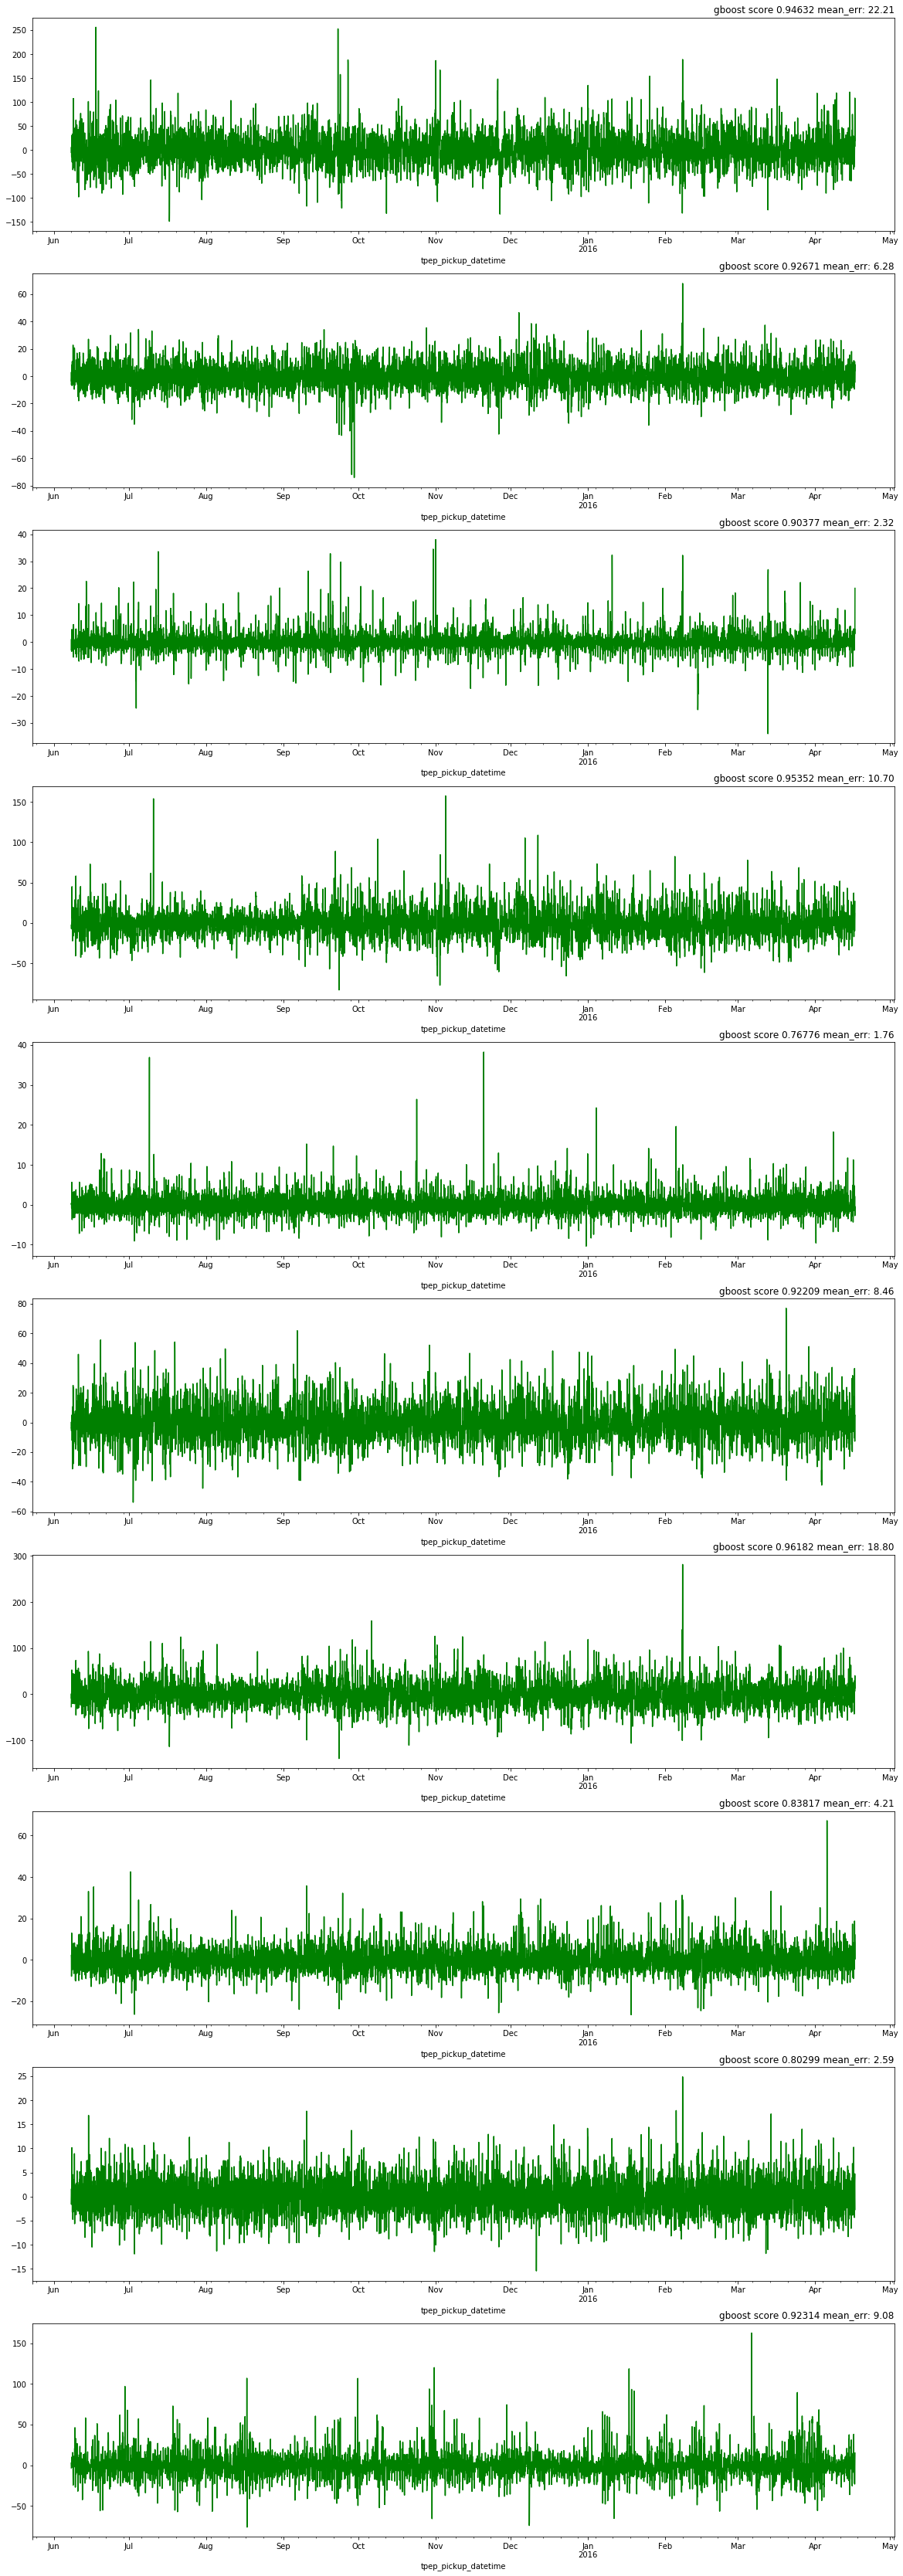

CPU times: user 48.2 s, sys: 695 ms, total: 48.9 s
Wall time: 53.8 s


In [10]:
%%time
gmodel = XGBRegressor(n_estimators=200)
fig, axes = plt.subplots(10, 1, figsize=(20,60))
start = 168
end = -168*2
g_score = []

for ind, i in enumerate(tests):
    col = str(i)
    ax = axes[ind]
    X = get_X_shifted(df, col)
    
    X = X[start:end, :]
    #  1 hour forward
    Y = df[col].shift(-1)[start:end].values
    
    gmodel.fit(X, Y)
    preds = gmodel.predict(X)
    score = r2_score(Y, preds)
    g_score.append(score)
    
    df['pred'] = 0
    df.loc[start:end, ['pred']] = preds
    df['pred'] = df['pred'].shift(1)
    df['dif'] = (df[col] - df['pred'])
    
    # plots
    title = "gboost score %.5f"%score
    mean_err = np.abs(Y - preds).mean()
    title += " mean_err: %.2f" % mean_err
    
    ax.set_title(title, loc='right')
    dif = df['dif'][start+1:end]
    dif.plot(ax=ax, color='g')
    print("errors for %s" % col, "mean trip count %.0f" % df[col].mean())
    print(dif[(dif.abs() > max(df[col].mean() / 3, 60))] )
plt.show()

Выведем полученные результаты

In [11]:
print("\t".join('%.3f'%x for x in g_score))

0.946	0.927	0.904	0.954	0.768	0.922	0.962	0.838	0.803	0.923


In [12]:
dif = np.array(g_score)
dif.mean()

0.8946289970200981

Загрузим данные за май и июнь

In [16]:
# загрузка данных за май и июнь
df_may = pd.read_csv('data/may16.csv', sep=';', parse_dates=l_parse_dates, index_col=l_index_col)
df_june = pd.read_csv('data/june16.csv', sep=';', parse_dates=l_parse_dates, index_col=l_index_col)
df1 = pd.concat((df, df_may), sort=True)
df2 = pd.concat((df1, df_june), sort=True)

In [17]:
timerange = pd.DatetimeIndex(freq='1H', start = '2016-04-30 23:00:00', end='2016-05-31 17:00:00')
X_may = get_X(pd.DataFrame(index=timerange))

In [18]:
print(X_may.shape)

(739, 64)


In [38]:
#%%time
gmodel = XGBRegressor(**params)

y = []

start = 169
end = -24
time_len = X_may.shape[0]
reg_count = regs.shape[0]
Q = 0

for reg in regs:
    col = str(reg)
    for t in range(6):
        # fit model
        shift = (t+1) * -1
        X_train = get_X_shifted(df, col)
        X_train = X_train[start:end, :]
        Y = df[col].shift(shift)[start:end].values
        gmodel.fit(X_train, Y)

        # getting y_true
        Y = df_may[col].shift(-t).values
        X_test = get_X_shifted(df1, col)
        X_test = X_test[-time_len-6:-6, :]
        
        preds = gmodel.predict(X_test)
        Q += (np.abs(preds - Y[:time_len])).sum()

In [39]:
print(Q / (6 * 739 * 102))

18.68153852451471


все прогнозы заняли около часа на том же железе, в сравнении с 2+ часами для SARIMAX.
Также, не требуется кластеризации, для каждого региона настраивалась своя модель.
точность выше чем на 4-й неделе 60.36610856860727.
 
подготовим код для результатов на каггл

In [40]:
timerange = pd.DatetimeIndex(freq='1H', start = '2016-05-31 23:00:00', end='2016-06-30 17:00:00')
X_june = get_X(pd.DataFrame(index=timerange))
print(X_june.shape)

(715, 64)


In [41]:
def get_date_str(time):
    return str(time.date()) + '_' + str(time.hour) + '_'

In [51]:
%%time

gmodel = XGBRegressor(**params)

y = []
time_len = X_june.shape[0]
reg_count = regs.shape[0]
Q = 0
header = 'id,y'

with open('data/output-june-gboost.csv', 'w', newline='\n') as f:
    f.write(header + '\n')
    
    for reg in regs:
        col = str(reg)
        reg_str = col + '_'
        
        preds_to_write = np.zeros((6, time_len))
        
        for t in range(6):
            # fit model
            shift = (t+1) * -1
            X_train = get_X_shifted(df1, col)
            X_train = X_train[start:end, :]
            Y = df1[col].shift(shift)[start:end].values
            gmodel.fit(X_train, Y)

            # getting y_true
            Y = df_june[col].shift(-t).values
            X_test = get_X_shifted(df2, col)
            X_test = X_test[-time_len-6:-6, :]

            preds = gmodel.predict(X_test)
            preds_to_write[t] = preds
            Q += (np.abs(preds - Y[:time_len])).sum()
              
        for ind, date in enumerate(timerange):
            date_str = get_date_str(date)
            for t, val in enumerate(preds_to_write[:, ind], 1):
                row = reg_str + date_str + str(t) + ',%.0f'%abs(round(val))
                f.write(row)
                f.write('\n')
        
        
print(Q / (6 * 102 * 715) )

17.133354830764016
CPU times: user 1h 47min 37s, sys: 41.7 s, total: 1h 48min 18s
Wall time: 1h 53min 57s


In [53]:
!head data/output-june-gboost.csv

id,y
1075_2016-05-31_23_1,33
1075_2016-05-31_23_2,20
1075_2016-05-31_23_3,11
1075_2016-05-31_23_4,3
1075_2016-05-31_23_5,2
1075_2016-05-31_23_6,8
1075_2016-06-01_0_1,14
1075_2016-06-01_0_2,7
1075_2016-06-01_0_3,3


Результаты с kaggle
89
new
Eugene K
34.36391